# Fall Detection using CNN-BiLSTM and WedaFall Dataset

## 1. Libraries and variables

In [1]:
from dataset.FallAllDDataset import FallAllDDataset
from utils.utils import plot_sensor_data
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import DataLoader, Subset
from collections import Counter
from models.CBAM_IAM_CNN_BiLSTM import CBAM_IAM_CNN_BiLSTM
from pytorch_lightning import Trainer
import wandb
from pytorch_lightning.loggers import WandbLogger
from datetime import datetime
import pandas as pd

dataset_path = "B:\\Dataset\\FallAllD\\"
learning_rate = 0.001
batch_size = 64
dropout = 0.3

## 2. Dataset

### 2.1 Dataset initialization

In [2]:
dataset = FallAllDDataset(dataset_path, accellerometer=True, gyroscope=False)

Processing files: 100%|██████████| 26420/26420 [00:29<00:00, 908.24it/s] 


### 2.2 Dataset exploration

In [3]:
print(f"Dataset length: {len(dataset)}")
classes = dataset.classes()
print(f"\tActivities: {classes[0]}")
print(f"\tFalls: {classes[1]}")

Dataset length: 1798
	Activities: 1332
	Falls: 466


#### 2.2.1 Sample data

Subject: 07, Activity: 109, Trial: 01, Label: 1
397 records in vertical accelerometer data


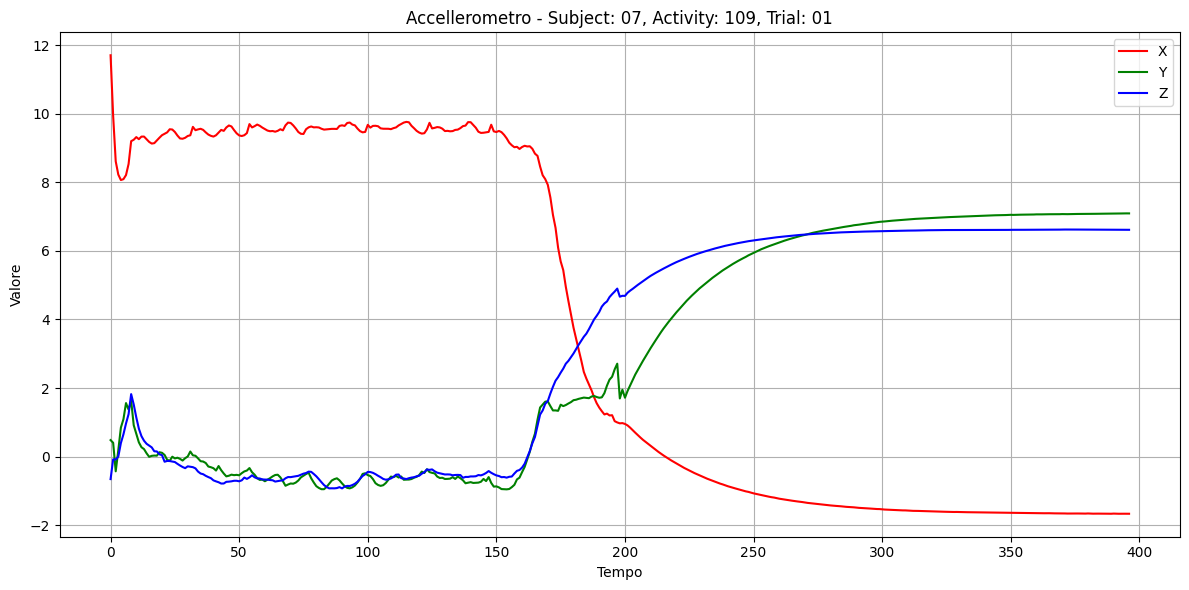

In [4]:
sample = dataset[811]
print(f"Subject: {sample['subject']}, Activity: {sample['activity']}, Trial: {sample['trial']}, Label: {sample['label']}")
print(f"{len(sample['A'])} records in vertical accelerometer data")

plot_sensor_data(pd.DataFrame(sample['A'], columns=['x', 'y', 'z']), sensor_type='A', labels=f"Accellerometro - Subject: {sample['subject']}, Activity: {sample['activity']}, Trial: {sample['trial']}")

### 2.3 Dataset statistics after preprocessing with windowing

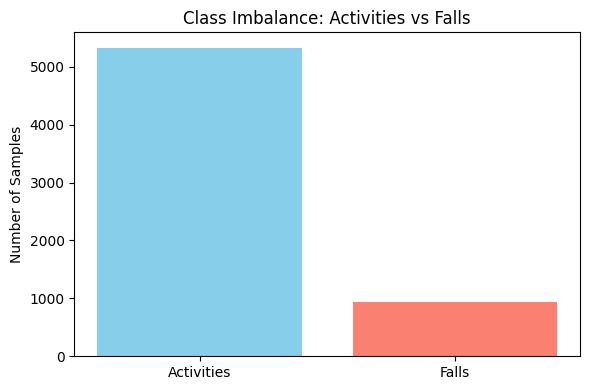

Dataset length: 6260
	Activities: 5328
	Falls: 932


In [5]:
dataset.setVisualization(False)

labels = ['Activities', 'Falls']
classes = dataset.classes()

plt.figure(figsize=(6, 4))
plt.bar(labels, [classes[0], classes[1]], color=['skyblue', 'salmon'])

plt.title('Class Imbalance: Activities vs Falls')
plt.ylabel('Number of Samples')
plt.tight_layout()
plt.show()

print(f"Dataset length: {len(dataset)}")
print(f"\tActivities: {classes[0]}")
print(f"\tFalls: {classes[1]}")

#### 2.3.1 Item example

In [6]:
features, label = dataset[4]
print(f"Label: {label}")
print(f"Features shape: {features.shape}")
print(features)

Label: 0
Features shape: (3, 140)
[[ 8.945033    9.006651    9.029595    9.029334    9.022015    9.014728
   9.00825     9.003265    9.005598    9.001713    9.004497    9.005656
   8.999775    8.998062    8.998215    9.003281    8.998883    8.996972
   8.998037    8.9949465   8.997513    8.99778     8.998648    8.999685
   8.999704    8.997335    8.99702     8.997482    8.997913    8.99873
   8.998079    8.99985     9.000835    9.00282     9.003656    9.004169
   9.004105    9.005312    9.006907    9.008248    9.008213    9.009913
   9.011107    9.01327     9.014917    9.014733    9.016138    9.016245
   9.016677    9.017825    9.017954    9.019048    9.020019    9.020952
   9.02201     9.021283    9.021295    9.020991    9.021326    9.019928
   9.021075    9.021715    9.018687    9.01886     9.019335    9.018408
   9.0192795   9.018894    9.0185995   9.018926    9.018325    9.017744
   9.016953    9.017255    9.017924    9.017815    9.01839     9.0177355
   9.018463    9.017203    9.0

In [7]:
random_state = 42
validation_and_test = 0.3
test_size = 0.6


labels = np.array([dataset[i][1] for i in range(len(dataset))])
indices = np.arange(len(labels))


train_idx, temp_idx, y_train, y_temp = train_test_split(indices, labels, test_size=validation_and_test, stratify=labels, random_state=random_state)
val_idx, test_idx, _, _ = train_test_split(temp_idx, y_temp, test_size=test_size, stratify=y_temp, random_state=random_state)


train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, persistent_workers=True)

#### 2.4.1 Class distribution

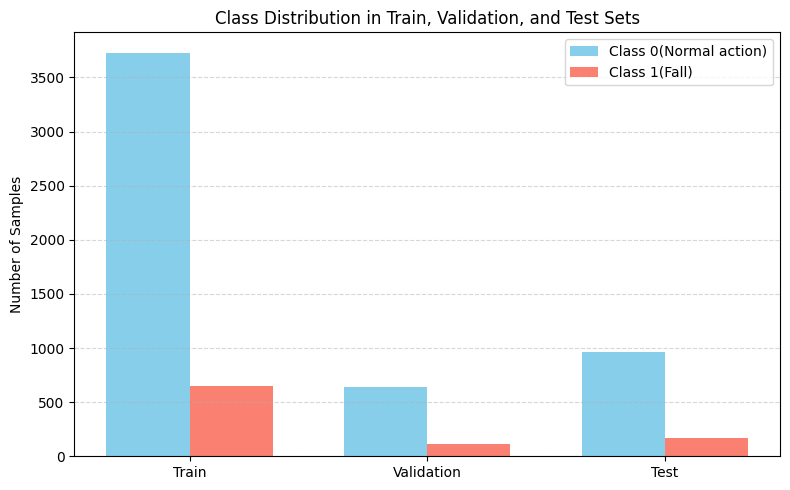

Train dataset length: 4382
Validation dataset length: 751
Test dataset length: 1127


In [8]:
def count_labels(dataloader):
    label_counter = Counter()
    for _, labels in dataloader:
        label_counter.update(labels.numpy().tolist())
    return label_counter

train_counts = count_labels(train_loader)
val_counts = count_labels(val_loader)
test_counts = count_labels(test_loader)


splits = ['Train', 'Validation', 'Test']
class_0 = [train_counts[0], val_counts[0], test_counts[0]]
class_1 = [train_counts[1], val_counts[1], test_counts[1]]

x = range(len(splits))
width = 0.35


plt.figure(figsize=(8, 5))
plt.bar(x, class_0, width=width, label='Class 0(Normal action)', color='skyblue')
plt.bar([p + width for p in x], class_1, width=width, label='Class 1(Fall)', color='salmon')

plt.xticks([p + width/2 for p in x], splits)
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Train, Validation, and Test Sets")
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

print(f"Train dataset length: {len(train_dataset)}")
print(f"Validation dataset length: {len(val_dataset)}")
print(f"Test dataset length: {len(test_dataset)}")

## 3. Model

In [9]:
from models.CoarseModel import CoarseFineGRU

model = CoarseFineGRU(weight=[train_counts[0], train_counts[1]], input_shape=(3,140), dropout=dropout)

#### 3.1 WandB integration

In [10]:
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

wandb_logger = WandbLogger(
    project="fall-detection",
    name=f"coarse-{timestamp}",
)

config = {
    "learning_rate": learning_rate,
    "batch_size": batch_size,
    "dropout": dropout,
    "model": "coarse",
}
wandb_logger.experiment.config.update(config)

wandb: Currently logged in as: zznnp (zznnp-sapienza-universit-di-roma) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


#### 3.2 Lightning module

In [11]:
trainer = Trainer(
    max_epochs=30,
    accelerator='gpu',
    devices=1,
    num_sanity_val_steps=0,
    check_val_every_n_epoch=1,
    enable_progress_bar=False,
    logger=wandb_logger
    #callbacks=[checkpoint_cb, earlystop_cb]
)

trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | coarse    | CoarseBranch     | 320    | train
1 | fine      | FineBranch       | 3.4 K  | train
2 | temporal  | TemporalBranch   | 38.2 K | train
3 | dropout   | Dropout          | 0      | train
4 | fc1       | Linear           | 649 K  | train
5 | fc2       | Linear           | 130    | train
6 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
691 K     Trainable params
0         Non-trainable params
691 K     Total params
2.765     Total estimated model params size (MB)
15        Modules in train mode
0        

In [12]:
res = trainer.test(model, dataloaders=test_loader)
print(f"Test results: {res}")

wandb.finish(0)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9574090242385864
         test_f1            0.9590625762939453
        test_loss           0.11566243320703506
     test_precision         0.9637779593467712
       test_recall          0.9574090242385864
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Test results: [{'test_loss': 0.11566243320703506, 'test_accuracy': 0.9574090242385864, 'test_precision': 0.9637779593467712, 'test_recall': 0.9574090242385864, 'test_f1': 0.9590625762939453}]


epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
test_accuracy,▁▁
test_f1,▁▁
test_loss,▁
test_precision,▁▁
test_recall,▁▁
train_acc_epoch,▇▁███▇█▇▇▇▇▇█▇██▇█████▇██▇█▇██
train_acc_step,▃▁▄▁▅▅▅█▆▆▅▆▇▅▆▅▅▇▇█▆▆▇▇▇▅▇▇▅█▆▆▇▇▆▆▅▇▅▇
train_loss_epoch,▇█▃▃▂▃▂▄▃▂▂▂▁▅▂▁▃▃▁▃▂▁▅▂▂▂▁▅▄▁
train_loss_step,▅▇▅▆▄▆▂▂▂▃▅▂▂▄▂▂▂▃▂▁▁▃▁▁▂▂▂▂▃▁█▁▂▂▂▁▃▁▃▁
trainer/global_step,▁▁▂▁▁▁▁▁▁▁▁▁▂▂▅▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂█▂▂▂▂▂▃
